In [6]:
import torch
import numpy as np
import dgl
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
def build_karate_club_graph():
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    u=np.concatenate([src,dst])
    v=np.concatenate([dst,src])
    return dgl.graph((u,v))

In [3]:
G=build_karate_club_graph()
print(G)
print("Nodes:" , G.number_of_nodes())
print("Edges:" , G.number_of_edges())

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})
Nodes: 34
Edges: 156


In [16]:
df = pd.read_csv("/home/kailash/CADS-code/dataset/knowledge-graph/cnn/BA.csv")
o=df['Open']
c=df['Close']
#opening=np.round(o)
#closing=np.round(c)
opening=o
closing=c
opening=opening.astype(int)
closing=closing.astype(int)
print(opening)
print(closing)
def stock_graph():
    a=np.concatenate([opening,closing])
    b=np.concatenate([closing,opening])
    return dgl.graph((a,b))
Sg=stock_graph()
print(Sg)
print("Nodes:",Sg.number_of_nodes())
print("Edges:",Sg.number_of_edges())

0        35.500000
1        36.187500
2        34.562500
3        33.875000
4        34.062500
           ...    
4641    169.740005
4642    170.410004
4643    173.919998
4644    174.979996
4645    175.970001
Name: Open, Length: 4646, dtype: float64
0        36.187500
1        35.250000
2        33.875000
3        34.000000
4        34.375000
           ...    
4641    170.809998
4642    172.710007
4643    175.559998
4644    175.360001
4645    176.860001
Name: Close, Length: 4646, dtype: float64


DGLError: Expect the source ID tensor to have data type int32 or int64, but got torch.float64.

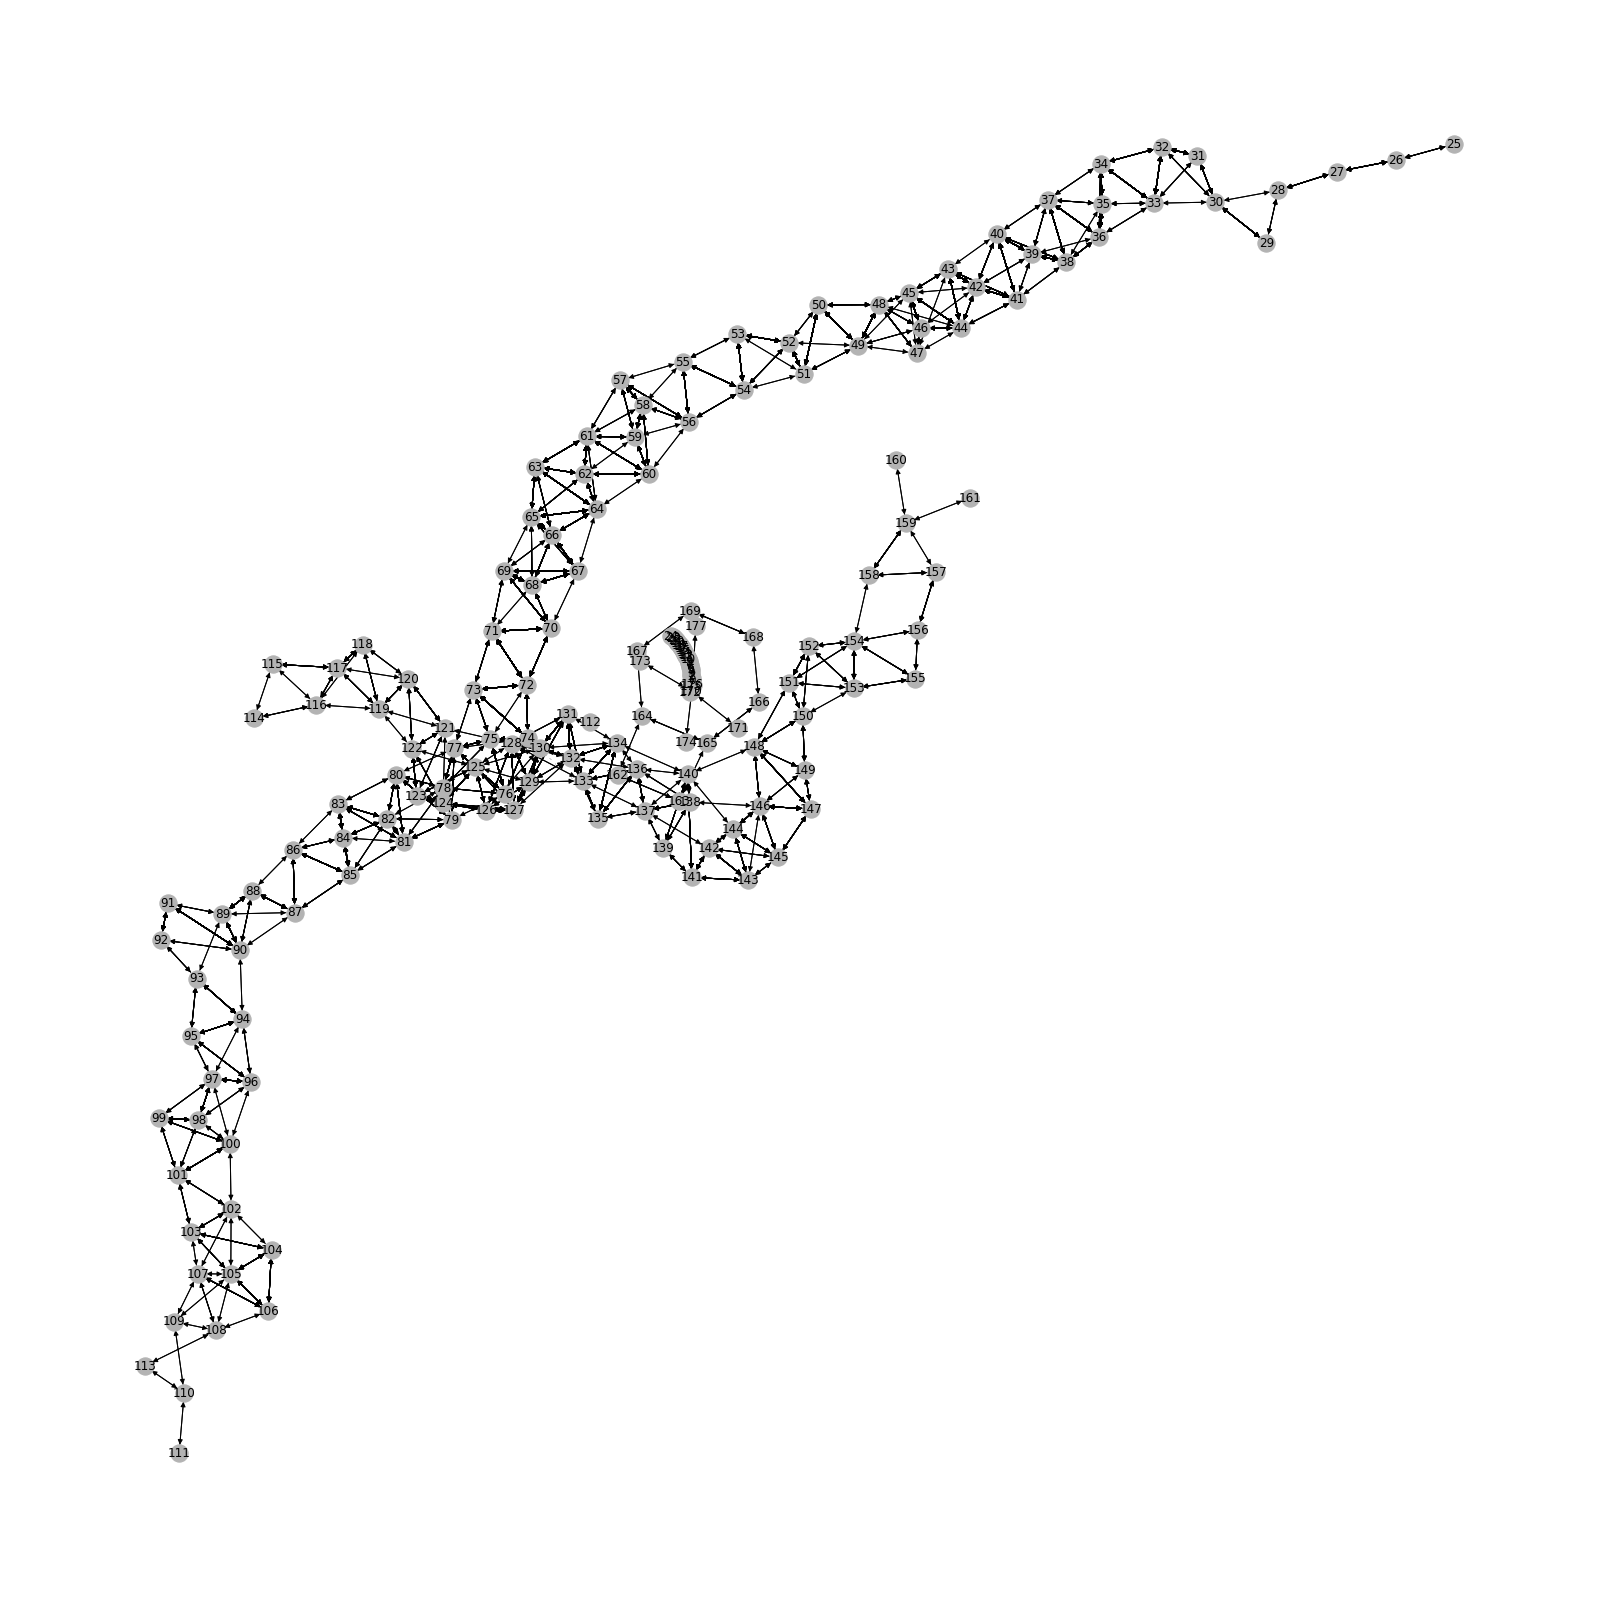

In [14]:
import networkx as nx
nx_Sg = Sg.to_networkx().to_directed()
plt.figure(1,figsize=(22,22))
pos=nx.kamada_kawai_layout(nx_Sg)
nx.draw(nx_Sg,pos,with_labels=True,node_color=[[0.7,0.7,0.7]])
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(178,5) #178 nodes with 5 dimensional embedding
Sg.ndata['Open'] = embed.weight
print(Sg.ndata['Open'][1])
print(Sg.ndata['Open'][[2,3]])

tensor([-1.2784, -1.0389,  1.1764, -0.1856,  0.6227], grad_fn=<SelectBackward>)
tensor([[-0.0959,  1.3092,  1.0688, -0.1796,  0.3882],
        [-1.1449,  0.5658, -1.2757, -1.1649, -0.4015]],
       grad_fn=<IndexBackward>)


In [8]:
from dgl.nn.pytorch import GraphConv
class GCN(nn.Module):
    def __init__(self,in_feats,hidden_size,num_classes):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(in_feats,hidden_size)
        self.conv2 = GraphConv(hidden_size,num_classes)
    
    def forward(self,g,inputs):
        h=self.conv1(g,inputs)
        h=torch.relu(h)
        h=self.conv2(g,h)
        return h

net=GCN(5,5,2)

In [9]:
inputs=embed.weight
labeled_nodes = torch.tensor([0,177])
labels = torch.tensor([0,1])

In [10]:
import itertools
opti = torch.optim.Adam(itertools.chain(net.parameters(),embed.parameters()),lr=0.01)
all_logits = []
Sg = dgl.add_self_loop(Sg)
for epoch in range(50):
    logits = net(Sg,inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits,1)
    loss = F.nll_loss(logp[labeled_nodes],labels)
    
    opti.zero_grad()
    loss.backward()
    opti.step()
    print('Epoch %d | Loss %.3f' % (epoch,loss.item()))

Epoch 0 | Loss 0.720
Epoch 1 | Loss 0.693
Epoch 2 | Loss 0.666
Epoch 3 | Loss 0.641
Epoch 4 | Loss 0.615
Epoch 5 | Loss 0.594
Epoch 6 | Loss 0.574
Epoch 7 | Loss 0.553
Epoch 8 | Loss 0.532
Epoch 9 | Loss 0.512
Epoch 10 | Loss 0.491
Epoch 11 | Loss 0.470
Epoch 12 | Loss 0.450
Epoch 13 | Loss 0.431
Epoch 14 | Loss 0.412
Epoch 15 | Loss 0.393
Epoch 16 | Loss 0.373
Epoch 17 | Loss 0.354
Epoch 18 | Loss 0.336
Epoch 19 | Loss 0.317
Epoch 20 | Loss 0.299
Epoch 21 | Loss 0.281
Epoch 22 | Loss 0.264
Epoch 23 | Loss 0.247
Epoch 24 | Loss 0.230
Epoch 25 | Loss 0.215
Epoch 26 | Loss 0.199
Epoch 27 | Loss 0.185
Epoch 28 | Loss 0.171
Epoch 29 | Loss 0.158
Epoch 30 | Loss 0.146
Epoch 31 | Loss 0.135
Epoch 32 | Loss 0.124
Epoch 33 | Loss 0.114
Epoch 34 | Loss 0.105
Epoch 35 | Loss 0.096
Epoch 36 | Loss 0.088
Epoch 37 | Loss 0.081
Epoch 38 | Loss 0.074
Epoch 39 | Loss 0.068
Epoch 40 | Loss 0.062
Epoch 41 | Loss 0.057
Epoch 42 | Loss 0.053
Epoch 43 | Loss 0.048
Epoch 44 | Loss 0.044
Epoch 45 | Loss 0.04